# Violent and Sexual Crime Rates by Municipality: The Netherlands, 2018

In [ ]:
# Libararies
import pandas as pd
import numpy as np
import geopandas as gpd         # make sure to import from its last version 
import matplotlib.pyplot as plt
%matplotlib inline

# Data 
## Accessing & Pre-processing
The data is sourced from the Centraal Bureau voor de Statistiek, Den Haag/Heerlen and can be accessed from https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=84468NED&_theme=395.

In [ ]:
# Access the crime data about 
df = pd.read_csv(r'C:\Users\murat\Downloads\84468NED_TypedDataSet_04012021_122231.csv', sep=';' , index_col=[0])
# Retain the columns of the analysis
df.drop(['WijkenEnBuurten', 'SoortRegio_2', 'Indelingswijziging_4', 'AantalInwoners_5',
       'TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27',
       'TotaalDiefstalUitWoningSchuurED_28',
       'VernielingMisdrijfTegenOpenbareOrde_29'], 
        axis=1, inplace=True)

# Remove white spaces from the categorical data
df['Codering_3'] = df['Codering_3'].str.strip()
df['Gemeentenaam_1'] = df['Gemeentenaam_1'].str.strip()

# Rename the columns
df.rename(columns = {'Gemeentenaam_1':'Municipality', 
                     'Codering_3' : 'Code', 
                     'GeweldsEnSeksueleMisdrijven_30' : 'Violent_and_sexual_crime'},
          inplace = True)

In [ ]:
# Access the geographic information data from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
mapdata = gpd.read_file(geodata_url)

In [ ]:
# Prepare the geographic data for merging:
# Clean white space and change data type from object to string 
mapdata['statnaam'] = mapdata['statnaam'].str.strip()
mapdata["statnaam"] = mapdata["statnaam"].astype('str')

### Merging the data

In [ ]:
# Join the geodataframe with the cleaned up csv dataframe
merged = mapdata.set_index('statcode').join(df.set_index('Code'))
merged.head(2)

# Analysis

Perform data visualization for Total Violent and Sexual Crime rate per 1000 inhabitants in each municipality, according to police records.  

In [11]:
# Display the municipalities with the highest crime rates of violent and sexual crime
crimebym = df.groupby('Municipality')['Violent_and_sexual_crime'].sum().sort_values(ascending=False)
crimebym = pd.DataFrame(crimebym)
print("Number of Municipality: ", len(crimebym))
crimebym.head()

Number of Municipality:  380


,Violent_and_sexual_crime
Municipality,
Amsterdam,8427.0
's-Gravenhage,2583.0
Haarlemmermeer,2320.0
Tilburg,2280.0
Arnhem,1831.0


Among 380 municipality recordings, the ones with the highest rates for Violent & Sexual Crime per 1000 inhabitants are identified in the following order: Amsterdam (8427), 's-Gravenhage (2583), Haarlemmermeer (2320), Tilburg (2280), and Arnhem (1831). 

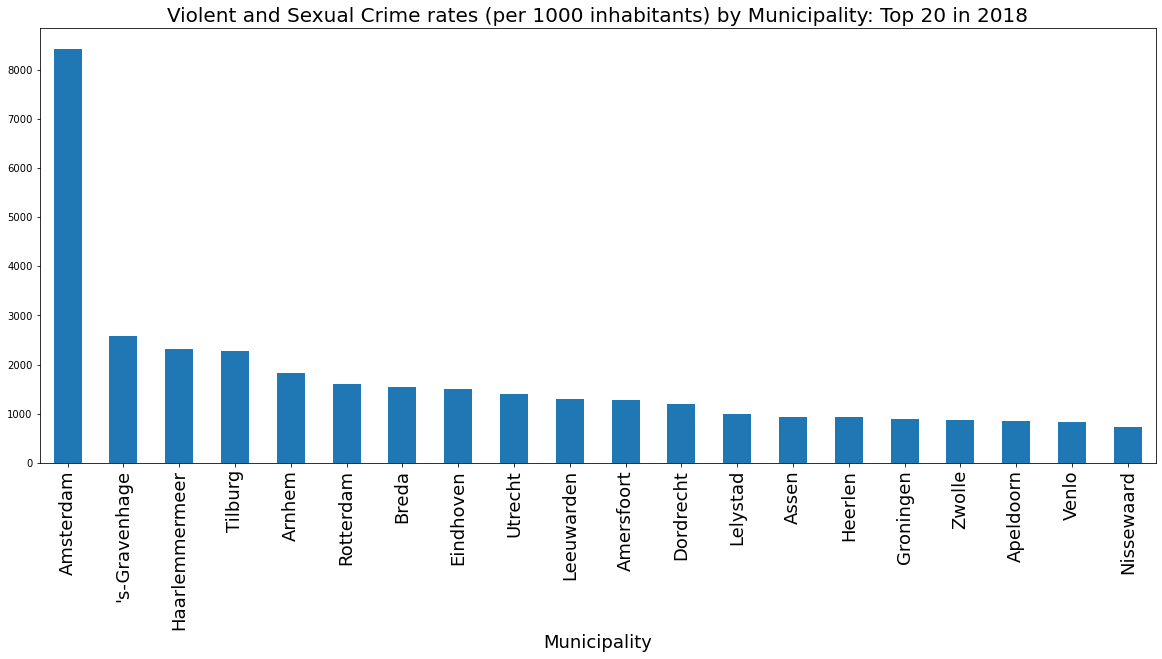

In [12]:
# Display the bar chart figure of the top 20 municipalities in term of crime rates
crimebym.head(20).plot(kind= 'bar', legend=False, figsize=(20,8))
plt.title('Violent and Sexual Crime rates (per 1000 inhabitants) by Municipality: Top 20 in 2018', 
          fontweight = 30, fontsize = 20)
plt.xlabel('Municipality', fontsize = 18)
plt.xticks(rotation = 90, fontsize = 18)
plt.show()


### Mapping

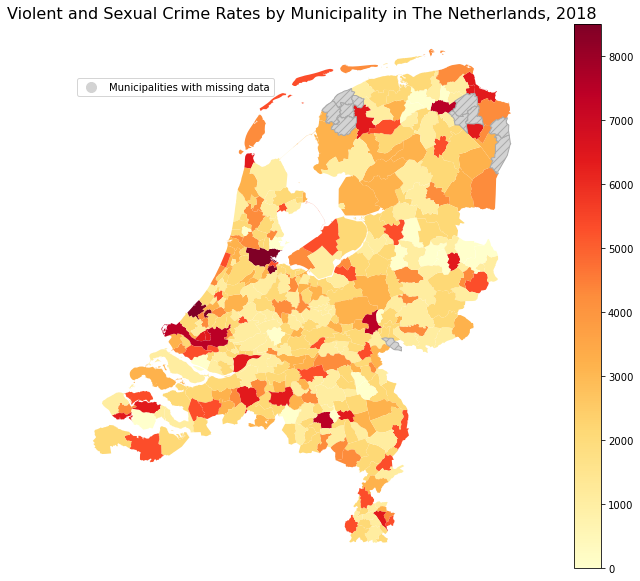

In [13]:
# Determine the size of the figure
fig, ax = plt.subplots(1, 1, figsize=[15,10])

# Create the map
nl_map = merged.plot(column='Violent_and_sexual_crime', 
                      ax=ax, 
                      cmap = 'YlOrRd', 
                      missing_kwds={'color': 'lightgrey', 'edgecolor': 'darkgrey', 
                                    'hatch': '///', 'label': 'Missing values'})
# Remove information from the axis
ax.axis('off')

# Create a colorbar as a legend
legend = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=8500))
fig.colorbar(legend)

# Create a patch for missing values
patch = plt.plot([],[], marker="o", ms=10, ls="", mec=None, color='lightgrey',
                 label= "Municipalities with missing data")
plt.legend(handles=patch, bbox_to_anchor=(0, 0.91),
           loc='upper left', ncol=2, facecolor=None, numpoints=1 )

# Add a title
ax.set_title('Violent and Sexual Crime Rates by Municipality in The Netherlands, 2018', fontsize=16)

# Save figure in the directory
fig.savefig('NL_crime_rates.png', dpi=300)

plt.show()